### 🍕 or 🍖
### 피자 이진 분류

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/pizza_not_pizza/original/'

idg = ImageDataGenerator()

generator = idg.flow_from_directory(root, target_size=(224, 224), batch_size=32, class_mode='binary')
print(generator.class_indices)

Found 1966 images belonging to 2 classes.
{'not_pizza': 0, 'pizza': 1}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'not_pizza', 1: 'pizza'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
df.file_paths = df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
df

,file_paths,target_names,targets
0,./datasets/pizza_not_pizza/original/not_pizza/...,not_pizza,0
1,./datasets/pizza_not_pizza/original/not_pizza/...,not_pizza,0
2,./datasets/pizza_not_pizza/original/not_pizza/...,not_pizza,0
3,./datasets/pizza_not_pizza/original/not_pizza/...,not_pizza,0
4,./datasets/pizza_not_pizza/original/not_pizza/...,not_pizza,0
...,...,...,...
1961,./datasets/pizza_not_pizza/original/pizza/9860...,pizza,1
1962,./datasets/pizza_not_pizza/original/pizza/9861...,pizza,1
1963,./datasets/pizza_not_pizza/original/pizza/9960...,pizza,1
1964,./datasets/pizza_not_pizza/original/pizza/9980...,pizza,1


In [5]:
df.targets.value_counts()

targets
0    983
1    983
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(df.file_paths, 
                 df.targets, 
                 stratify=df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
1    786
0    786
Name: count, dtype: int64
targets
1    197
0    197
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, 
                 train_targets, 
                 stratify=train_targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
1    629
0    628
Name: count, dtype: int64
targets
0    158
1    157
Name: count, dtype: int64
targets
1    197
0    197
Name: count, dtype: int64


In [8]:
train_df = df.iloc[train_images.index].reset_index(drop=True)
validation_df = df.iloc[validation_images.index].reset_index(drop=True)
test_df = df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(1257, 3)
(315, 3)
(394, 3)


#### 📌 IMAGE 확인

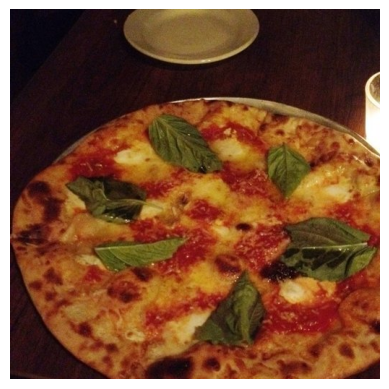

In [9]:
import cv2 
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[63]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 224
BATCH_SIZE = 32

def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.Compose([A.HorizontalFlip(p=0.5), 
                     A.VerticalFlip(p=0.5), 
                     A.OneOf([A.ColorJitter(p=1), 
                              A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)], 
                             p=1)], p=0.5)
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)


# flow_from_dataframe에서 y_col에 들어갈 타겟 데이터는 문자열 타입만 가능하다.
train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 1257 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.
Found 394 validated image filenames belonging to 2 classes.
{'not_pizza': 0, 'pizza': 1}
{'not_pizza': 0, 'pizza': 1}
{'not_pizza': 0, 'pizza': 1}


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/pizza/mobilenet/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.keras",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

### 🖥️ Cycle 1. MobileNet

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(1.0000e-05), loss=BinaryCrossentropy(), metrics=['acc'])

C:\Users\user\AppData\Local\Temp\ipykernel_26908\1842070105.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,085 (8.86 MB)

 Trainable params: 2,287,973 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [14]:
import gc

gc.collect()

833

In [15]:
N_EPOCHS = 20

history = model.fit(train_flow, 
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 730ms/step - acc: 0.5421 - loss: 0.8027 - val_acc: 0.6063 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step - acc: 0.5410 - loss: 0.7758 - val_acc: 0.6508 - val_loss: 0.6507 - learning_rate: 1.0000e-05
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 700ms/step - acc: 0.5667 - loss: 0.7142 - val_acc: 0.6857 - val_loss: 0.6120 - learning_rate: 1.0000e-05
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 703ms/step - acc: 0.5581 - loss: 0.7206 - val_acc: 0.7111 - val_loss: 0.5714 - learning_rate: 1.0000e-05
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 701ms/step - acc: 0.5968 - loss: 0.6625 - val_acc: 0.7460 - val_loss: 0.5371 - learning_rate: 1.0000e-05
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 768ms/step - acc: 0.5940 - loss: 0.6726 - val_acc: 0.7587 - val_loss: 0.5062 - learning_rate: 1.0000e-05
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 824ms/step - acc: 0.6105 - loss: 0.6366 - val_acc: 0.7841 - val_loss: 0.4782 - learning

In [18]:
model.evaluate(test_flow)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - acc: 0.8545 - loss: 0.3408


[0.3580983877182007, 0.8426395654678345]

In [19]:
model.evaluate(train_flow)

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - acc: 0.6927 - loss: 0.5161


[0.5078951716423035, 0.7024661898612976]

In [20]:
model.evaluate(validation_flow)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - acc: 0.8878 - loss: 0.2658


[0.2825597822666168, 0.8857142925262451]

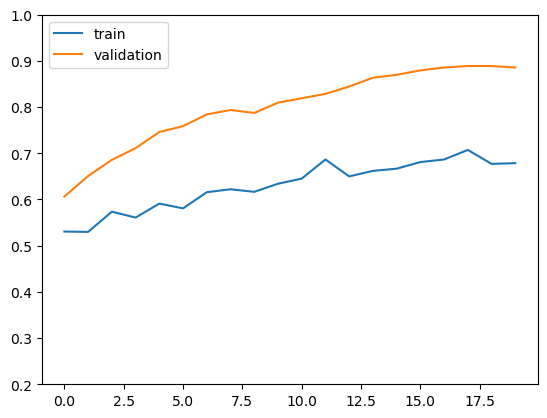

In [22]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.ylim(0.2, 1.0)
    plt.show()
    
show_history(history)

### 📋 Cycle 1. MobileNet 결과
1. acc와 val_acc 향상
   - acc가 epoch를 반복할 때마다 점진적으로 향상 되고 있습니다.
2. loss와 val_acc 개선
   - loss가 epoch를 반복할 때마다 계속 개선되고 있습니다.
3. flow
   - test_flow와 validation_flow가 모두 acc가 0.85, 0.88로 높고, loss 값도 0.26, 0.34로 낮습니다.
   - 이 점을 미루어보아 과적합 없이 잘 훈련이 된듯 합니다. 

### 🎯 Cycle 1. MobileNet 실제 예측

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


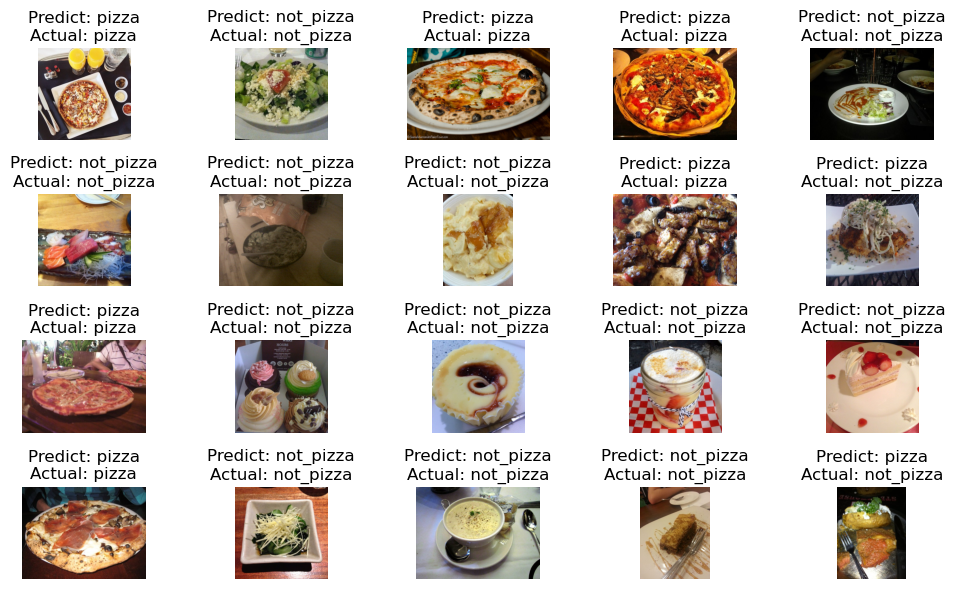

In [26]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

IMAGE_DIR = './datasets/pizza_not_pizza/original/'
class_names = ['not_pizza', 'pizza']

def load_random_images(image_dir, class_names, num_images=20):
    selected_classes = random.choices(class_names, k=num_images)
    images = []
    labels = []
    
    for class_name in selected_classes:
        class_dir = os.path.join(image_dir, class_name)
        all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpg')]
        selected_image = random.choice(all_images)
        images.append(selected_image)
        labels.append(class_name)
    
    return images, labels

def preprocess_image(image_path, image_size, mode='tf'):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (image_size, image_size))
    preprocessed_image = preprocessing_scaling(resized_image, mode=mode)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    return preprocessed_image

random_images, random_labels = load_random_images(IMAGE_DIR, class_names, num_images=20)

plt.figure(figsize=(10, 6))

for idx, image_path in enumerate(random_images):
    preprocessed_image = preprocess_image(image_path, IMAGE_SIZE, mode='tf')
    predictions = model.predict(preprocessed_image)
    predicted_class = int(predictions[0] > 0.5)
    predicted_class_name = class_names[predicted_class]
    
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, idx + 1)
    plt.imshow(image)
    plt.title(f"Predict: {predicted_class_name}\nActual: {random_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

---

### 🎯 Cycle 1. MobileNet 실제 예측 결과

<img src="./datasets/pizza_not_pizza/tst/predict_pz_mobilenet1.png">
<img src="./datasets/pizza_not_pizza/tst/predict_pz_mobilenet2.png">

- original 폴더에서 20개를 랜덤하게 뽑아 예측 했을 때, 20개씩 2번 총 40개 중 3개를 틀리고 37개를 맞췄습니다.
- 대략 92%의 정확도를 나타냅니다.  
- 성능이 매우 우수합니다.  

#### 다음으로는 VGG16을 사용해서 훈련을 진행 해보겠습니다.

### 🖥️ Cycle 2. VGG16

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 224
BATCH_SIZE = 32

def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.Compose([A.HorizontalFlip(p=0.5), 
                     A.VerticalFlip(p=0.5), 
                     A.OneOf([A.ColorJitter(p=1), 
                              A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)], 
                             p=1)], p=0.5)
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)


# flow_from_dataframe에서 y_col에 들어갈 타겟 데이터는 문자열 타입만 가능하다.
train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 1257 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.
Found 394 validated image filenames belonging to 2 classes.
{'not_pizza': 0, 'pizza': 1}
{'not_pizza': 0, 'pizza': 1}
{'not_pizza': 0, 'pizza': 1}


In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/pizza/vgg16/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.keras",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [82]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


model = create_model(model_name='vgg16', verbose=True)
model.compile(optimizer=Adam(1.0000e-04), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 50)                  │          25,6

 Total params: 14,740,389 (56.23 MB)

 Trainable params: 14,740,389 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
import gc

gc.collect()

2211

In [84]:
N_EPOCHS = 20

history = model.fit(train_flow, 
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - acc: 0.5655 - loss: 0.6779 - val_acc: 0.8889 - val_loss: 0.4003 - learning_rate: 1.0000e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - acc: 0.6304 - loss: 0.5824 - val_acc: 0.8921 - val_loss: 0.2557 - learning_rate: 1.0000e-04
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - acc: 0.6742 - loss: 0.5342 - val_acc: 0.8889 - val_loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - acc: 0.6880 - loss: 0.5010 - val_acc: 0.9048 - val_loss: 0.2598 - learning_rate: 1.0000e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - acc: 0.7026 - loss: 0.4656 - val_acc: 0.9270 - val_loss: 0.1868 - learning_rate: 1.0000e-05
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - acc: 0.7227 - loss: 0.4426 - val_acc: 0.9270 - val_loss: 0.2068 - learning_rate: 1.0000e-05
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - acc: 0.7141 - loss: 0.4278 - val_acc: 0.9238 - val_loss: 0.1853 - learning_rate: 1.0000e

In [85]:
model.evaluate(test_flow)

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 947ms/step - acc: 0.8996 - loss: 0.2331


[0.2513449490070343, 0.8908629417419434]

In [86]:
model.evaluate(train_flow)

40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.7419 - loss: 0.4117


[0.39584121108055115, 0.7414478659629822]

In [87]:
model.evaluate(validation_flow)

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.9155 - loss: 0.2095


[0.17585013806819916, 0.9301587343215942]

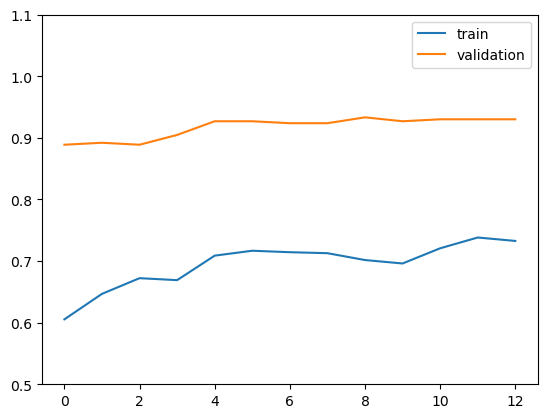

In [88]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.ylim(0.5, 1.1)
    plt.show()
    
show_history(history)

### 📋 Cycle 2. VGG16 결과

1. val_acc
   - val_acc는 전반적으로 0.88에서 0.93사이에서 안정적으로 유지되고 있습니다.
2. loss
   - 초기 epoch에서 epoch를 반복할 동안 꾸준히 개선되고 있습니다.
3. flow
   - test_flow와 validation_flow가 모두 acc가 0.89, 0.91로 높고, loss 값도 0.23, 0.2로 낮습니다.
   - 이 점을 미루어보아 과적합 없이 잘 훈련이 된듯 합니다. 

### 🎯 Cycle 2. VGG16 실제 예측

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


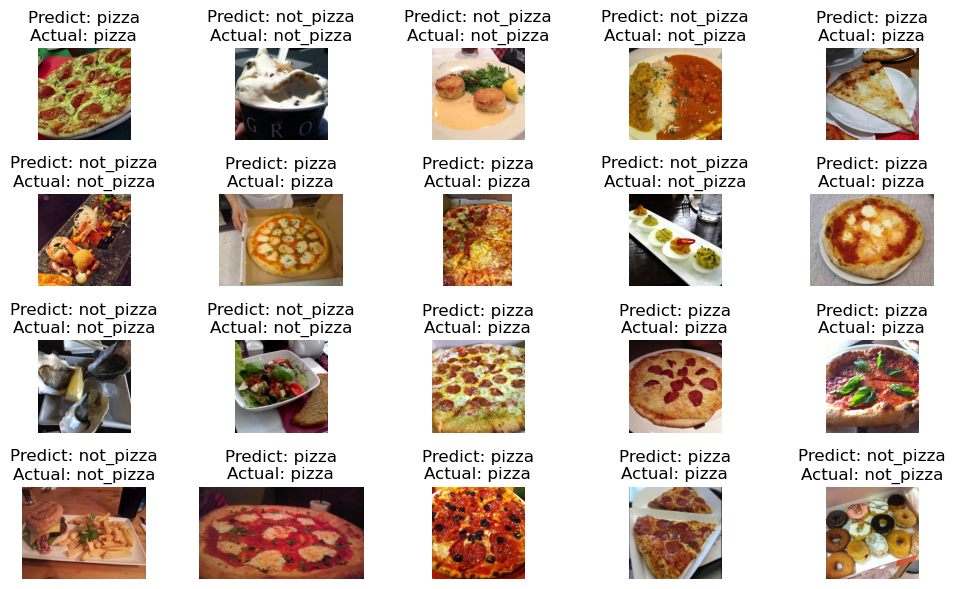

In [93]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

IMAGE_DIR = './datasets/pizza_not_pizza/original/'
class_names = ['not_pizza', 'pizza']

def load_random_images(image_dir, class_names, num_images=20):
    selected_classes = random.choices(class_names, k=num_images)
    images = []
    labels = []
    
    for class_name in selected_classes:
        class_dir = os.path.join(image_dir, class_name)
        all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpg')]
        selected_image = random.choice(all_images)
        images.append(selected_image)
        labels.append(class_name)
    
    return images, labels

def preprocess_image(image_path, image_size, mode='tf'):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (image_size, image_size))
    preprocessed_image = preprocessing_scaling(resized_image, mode=mode)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    return preprocessed_image

random_images, random_labels = load_random_images(IMAGE_DIR, class_names, num_images=20)

plt.figure(figsize=(10, 6))

for idx, image_path in enumerate(random_images):
    preprocessed_image = preprocess_image(image_path, IMAGE_SIZE, mode='tf')
    predictions = model.predict(preprocessed_image)
    predicted_class = int(predictions[0] > 0.5)
    predicted_class_name = class_names[predicted_class]
    
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, idx + 1)
    plt.imshow(image)
    plt.title(f"Predict: {predicted_class_name}\nActual: {random_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

---

### 🎯 Cycle 2. VGG16 실제 예측 결과

<img src="./datasets/pizza_not_pizza/tst/predict_pz_vgg161.png">
<img src="./datasets/pizza_not_pizza/tst/predict_pz_vgg162.png">

- original 폴더에서 20개를 랜덤하게 뽑아 예측 했을 때, 20개씩 2번 총 40개 중 2개를 틀리고 38개를 맞췄습니다.
- 대략 95%의 정확도를 나타냅니다.  
- 성능이 매우 우수합니다.

### 📋 Cycle 1, 2 비교

1. MobileNet
   - MobileNet의 실제 예측 정확도는 92.5% 였습니다.
   - MobileNet의 장점인 적은 파라미터 수와 적은 메리를 사용하기 때문에 훈련 속도가 30초대로 매우 빨랐습니다.
2. VGG16
   - VGG16의 실제 예측 정확도는 95% 였습니다.
   - VGG 모델은 깊은 구조를 통행 다양한 이미지 분류에서 높은 성능을 발휘 합니다.
   - 하지만, 매우 많은 파라미터를 가지고 있어 메모리 사용량이 높고 저장 공간을 차지하여 연산속도가 MobileNet보다 연산 속도가 더 느립니다.

## ∴
<strong>위의 내용에 따라 더 높은 성능을 가지고 있는 VGG16 모델을 Fine Tuning을 통해 여러 방면의 성능을 더 증대 시켜보도록 하겠습니다.</strong>

### 🖥️ Cycle 3. VGG16 Fine Tuning

In [48]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 150
BATCH_SIZE = 32

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            # 에포크 종료 시, 객체 생성 및 데이터 섞기
            self.on_epoch_end()

    # __len__()는 전체 데이터 건수에서 batch_size 단위로 나눈 데이터 수
    # 예를 들어, 1000개의 데이터를 30 batch_size로 설정하면, 1 batch당 33.33..개이다.
    # 이 때, 소수점은 무조건 올려서 33 + 1 = 34개로 설정한다.
    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [49]:
import albumentations as A
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input


train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values


aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.OneOf([A.ColorJitter(p=1), 
             A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)], 
            p=1)], p=0.5)

train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=vgg16_preprocess_input, 
                        shuffle=True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=vgg16_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=vgg16_preprocess_input)

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [56]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='vgg16', verbose=True)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │          25,6

 Total params: 14,740,389 (56.23 MB)

 Trainable params: 14,740,389 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

### 🛠️ Fine Tuning 설정

❗ 현재 데이터 세트는 데이터의 갯수가 2000개 정도로 적고, 유사도도 높습니다.  
∴ 따라서  
<br>
<img src="./images/transfer_learning04.png" width="300">
<br>

<strong>이 이미지에 따라 4/4분면의 내용과 같이 'convolutional base' 를 모두 'Freeze' 하고 다시 훈련을 시켜보도록 하겠습니다.</strong>

### 🔍 VGG16 Model의 Layer 확인

In [57]:
model.layers

[<InputLayer name=input_layer_5, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_5, built=True>,
 <Dense name=dense_5, built=True>,
 <Dense name=output, built=True>]

### 🛠️Fine Tune 세부 조정
위 레이어들을 확인 했을 때,  
맨 아래에서 3번째부터가 Classifier Layer이기 때문에 마지막 3개를 제외한 다른 레이어들은  
layer.trainable = False로 설정하겠습니다.

In [98]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input


IMAGE_SIZE = 150
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=vgg16_preprocess_input, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=vgg16_preprocess_input)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    model.compile(optimizer=Adam(0.00001), loss=BinaryCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [99]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.OneOf([A.ColorJitter(p=1), 
             A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)], 
            p=1)], p=0.5)

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 50)                  │          25,6

 Total params: 14,740,389 (56.23 MB)

 Trainable params: 14,740,389 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 566ms/step - acc: 0.6556 - loss: 1.6615 - val_acc: 0.9143 - val_loss: 0.3226
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 565ms/step - acc: 0.8985 - loss: 0.3109 - val_acc: 0.9079 - val_loss: 0.2761
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 587ms/step - acc: 0.8954 - loss: 0.2963 - val_acc: 0.9206 - val_loss: 0.2850
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 594ms/step - acc: 0.9175 - loss: 0.2024 - val_acc: 0.9143 - val_loss: 0.2558
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 597ms/step - acc: 0.9454 - loss: 0.1490 - val_acc: 0.9175 - val_loss: 0.2454
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 588ms/step - acc: 0.9389 - loss: 0.1447 - val_acc: 0.9238 - val_loss: 0.2465
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 579ms/step - acc: 0.9614 - loss: 0.1018 - val_acc: 0.9270 - val_loss: 0.2172
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 578ms/step - acc: 0.9460 - loss: 0.1363 - val_acc: 0.9333 - val_loss: 0.2207
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 572ms/

In [100]:
model.evaluate(test_dataset, batch_size=BATCH_SIZE)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - acc: 0.9022 - loss: 0.4524


[0.3659210503101349, 0.9010152220726013]

In [101]:
model.evaluate(train_dataset, batch_size=BATCH_SIZE)

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 450ms/step - acc: 0.9751 - loss: 0.0789


[0.08683785051107407, 0.9753381013870239]

In [102]:
model.evaluate(validation_dataset, batch_size=BATCH_SIZE)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 451ms/step - acc: 0.9526 - loss: 0.2006


[0.19173137843608856, 0.9460317492485046]

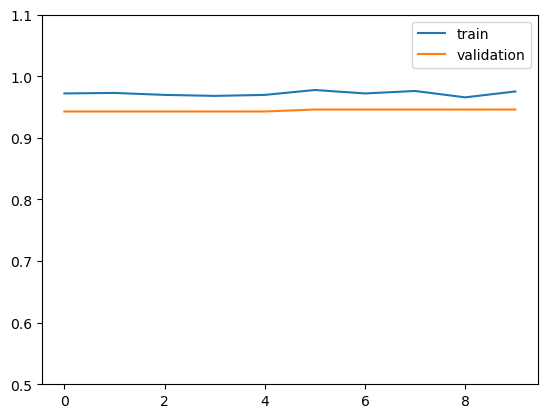

In [103]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.ylim(0.5, 1.1)
    plt.show()
    
show_history(history)

### 📋 Cycle 2. VGG16 Fine Tuning 결과

1. acc
   -  epoch를 반복할 수록 상승하여 0.975까지 상승하였습니다.
2. val_acc
   - 0.91에서 0.946까지 상승하였습니다.
3. loss, val_loss
   - loss와 val_loss 모두 안정적이고 지속적으로 개선 되었습니다.
4. 1개 epoch 당 훈련 속도다 20초 대로 매우 빨라졌습니다.

<strong>∴ 위의 내용을 토대로 해당 모델은 과적합 없이 안정적인 학습이 이루어졌다고 볼 수 있습니다.</strong>

### 🎯 Cycle 3. VGG16 Fine Tuning 실제 예측

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


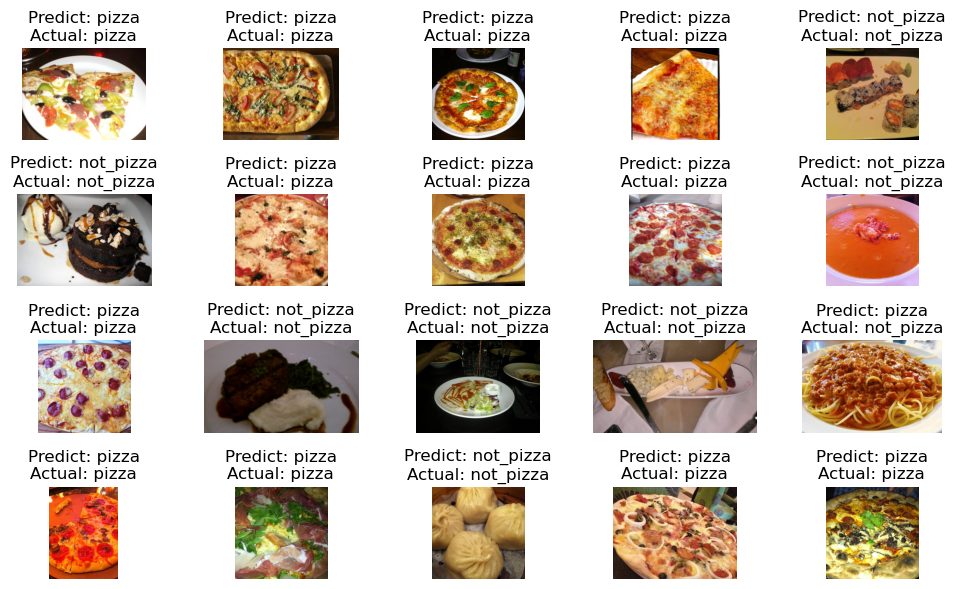

In [109]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

IMAGE_DIR = './datasets/pizza_not_pizza/original/'
class_names = ['not_pizza', 'pizza']

def load_random_images(image_dir, class_names, num_images=20):
    """
    주어진 디렉토리에서 무작위로 이미지를 로드하고, 해당 이미지를 클래스 이름과 함께 반환합니다.
    """
    selected_classes = random.choices(class_names, k=num_images)
    images = []
    labels = []
    
    for class_name in selected_classes:
        class_dir = os.path.join(image_dir, class_name)
        all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpg')]
        selected_image = random.choice(all_images)
        images.append(selected_image)
        labels.append(class_name)
    
    return images, labels

def preprocess_image(image_path, image_size):
    """
    이미지를 로드하고, 전처리하여 반환합니다.
    """
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (image_size, image_size))
    preprocessed_image = vgg16_preprocess_input(resized_image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    return preprocessed_image

# 무작위로 이미지를 로드
random_images, random_labels = load_random_images(IMAGE_DIR, class_names, num_images=20)

# 플롯 설정
plt.figure(figsize=(10, 6))

# 이미지 예측 및 시각화
for idx, image_path in enumerate(random_images):
    preprocessed_image = preprocess_image(image_path, IMAGE_SIZE)  # 이미지 전처리
    predictions = model.predict(preprocessed_image)  # 모델 예측
    predicted_class = int(predictions[0] > 0.5)  # 예측 결과를 이진 클래스(0 또는 1)로 변환
    predicted_class_name = class_names[predicted_class]  # 예측된 클래스 이름

    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # 이미지를 로드하고 BGR에서 RGB로 변환
    plt.subplot(4, 5, idx + 1)  # 4x5 그리드의 서브플롯에 이미지 추가
    plt.imshow(image)  # 이미지를 플롯에 표시
    plt.title(f"Predict: {predicted_class_name}\nActual: {random_labels[idx]}")  # 예측 결과와 실제 라벨을 제목으로 표시
    plt.axis('off')  # 축 표시 제거

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 플롯을 화면에 표시


---

### 🎯 Cycle 3. VGG16 Fine Tuning 실제 예측 결과

<img src="./datasets/pizza_not_pizza/tst/predict_pz_vgg161fine.png">
<img src="./datasets/pizza_not_pizza/tst/predict_pz_vgg162fine.png">

- original 폴더에서 20개를 랜덤하게 뽑아 예측 했을 때, 20개씩 2번 총 40개 중 1개를 틀리고 39개를 맞췄습니다.
- 대략 97.5%의 정확도를 나타냅니다.  
- 성능이 매우 우수합니다.

---

### 📋Total Cycle Result

<img src="./datasets/pizza_not_pizza/tst/vgg_fine_tune1.png" style="margin-bottom:20px">
<br>
<img src="./datasets/pizza_not_pizza/tst/vgg_fine_tune2.png">

- VGG16 기준으로, 
- Fine Tuning 전에는 1개의 epoch 당 대략 170초 정도 걸렸지만,
- FIne Tuning 후에는 1개의 epoch 당 대략 24초 정도로 대략 7배정도 연산 속도가 빨라졌습니다.
- 이는, 해당 데이터세트의 특성을 고려하여 VGG16 모델의 'convolutional base'를 모두 Freeze 했기 때문에 연산속도가 매우 빨라졌습니다.

∴ VGG16 모델 자체만으로도 성능이 좋지만, Fine Tuning을 적용함으로서 비슷한 성능이지만, 더 빠른 연산속도로를 얻을 수 있게 되었습니다.